In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore", FutureWarning)

### 1

In [2]:
BASE_DIR = Path().resolve().parent.parent.parent
DATA_DIR = BASE_DIR / "redes_neurais" / "atividades" / "dados" / "data"

In [3]:
titanic_df = pd.read_csv(DATA_DIR / "train.csv")

### 2

O dataset Spaceship Titanic trata os dados dos passageiros da viagem do Titanic em formato de sátira, onde os passageiros estão em uma viagem espacial e sofrem uma anomalia, causando muitas mortes. A ideia aqui é desafiar as pessoas a explorar os dados dos passageiros da viagem para descobrir quem foram os sobreviventes, com base nas informações de cada um, como por exemplo, nível de cabine, idade, a cidade de destino e etc.

A variável 'Transported' referencia se o passageiro morreu ou não, isto é, foi transportado para uma outra dimensão. Dessa forma, caso seja True seu valor, o passageiro morreu no acidente, e o contrário não.

O restantes das variávies indepentes trazem algumas informações como:
- PassengerId: ID do passageiro, com os quatro primeiros dígitos sendo o grupo de pessoas que ele está viajando e os dois últimos o seu id dentro do grupo.
- Name: O nome completo do passageiro.
- HomePlanet: Onde o passageiro mora.
- CryoSleep: Variável booleana se o passageiro escolheu ficar em hibernação durante a viagem. Se sim, isso indica que eles ficaram presos nas suas cabines.
- Cabin: O número da cabine e onde ela está localizada na nave. (Deck/Número do quarto/Lado)
- Destination: O destino do passageiro.
- Age: A idade do passageiro.
- VIP: Variável booleana se o passageiro pagou para ter tratamentos VIPs durante a viagem.
- RoomService: Valores gasto pelo passageiro no serviço de quarto.
- FoodCourt: Valores gasto pelo passageiro no restaurante.
- ShoppingMall: Valores gasto pelo passageiro no shopping da nave.
- Spa: Valores gasto pelo passageiro no Spa.
- VRDeck: Valores gasto pelo passageiro no Deck.

In [4]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


O dataset possui 8693 linhas, com todas colunas com valores faltantes, exceto o PassengerId e Transported que são o identificador único do passageiro e a variável dependente.

### 3

Para lidar com os dados faltantes, é necessário separamos elas entre númericas e categóricas:

**CATEGÓRICAS:**
- HomePlanet
- CryoSleep
- Cabin
- Destination
- VIP
- Name

**NÚMERICAS:**
- Age
- RoomService
- FoodCourt
- ShoppingMall
- Spa
- VRDeck

Com relação as categóricas, precisaremos analisar caso a caso. No caso de *HomePlanet* que representa a origem do passageiro, podemos utilizar a moda como forma de input dos dados faltantes. No caso de *CryoSleep* que é a booleana referente ao passageiro que optou por ficar em hibernação durante a viagem, essa é uma varíavel passível de ser predita a partir das outras variáveis como por exemplo os gastos nos estabelecimentos. No entanto, por questões de simplificação, utilizarei apenas a moda como forma de input. Já para o caso da *Cabin*, utilizarei a moda, porém separadas por duas variáveis que acredito serem relevantes para a escolha da ala da nave. A primeira, se a pessoa escolheu viajar hibernando, e a segunda, caso a primeira seja falsa, é se o passageiro é um VIP ou não. A partir disso eu utilizarei a moda dessas separações. Uma coisa importante de pontuar, é que eu vou utilizar a variável de Cabine de uma form diferente, eu vou retirar o número da cabine em si e vou fazer a moda das combinações de (deck/side). Para *Destination* eu utilizarei a mesma técnicas usada para *HomePlanet*, aplicando apenas a moda. Para a variável *VIP*, utilizarei a mesma ideia de *Cabin*, pegando a mediana do grupo de passageiros VIPs e não VIPs e a partir dos gastos dos passageiros sem rótulo de VIP, eu aplicarei eles a mediana mais próxima. E por fim, as variáveis Nome e PassengerID, por serem varíaveis identificadoras dos indivíduos, não serão usadas, para não criar um viés na rede.

Já sobre as númericas, a variável *Age* será preenchida com a mediana dos passageiros, por ser a forma mais estável e que traz, em teoria, menos viés para a rede. Já as variáveis de gasto nos estabelecimentos: RoomService; FoodCourt; ShoppingMall; Spa; VRDeck, serão preenchidas com a seguinte regra. Se a pessoa tem a variável *CryoSleep* igual a True, todo valor faltantes será preenchido com zero, afinal, ela estava hibernando e não gastou nada. Agora já aqueles passageiros com *CryoSleep* igual a False, ou com essa variável, também com o dado faltante, os gastos serão preenchidos com base na média dos gastos nos outros estabelecimentos, afinal, não tem nenhum passageiro com todas as variáveis de consumo vazias ao mesmo tempo.

In [5]:
process_titanic_df = titanic_df.copy()

In [6]:
process_titanic_df.HomePlanet.fillna(process_titanic_df.HomePlanet.mode()[0], inplace=True)

In [7]:
deck_hiberna, side_hiberna = (
    process_titanic_df.query("CryoSleep == True").Cabin.mode()[0].split("/")[0:3:2]
)
deck_VIP, side_VIP = (
    process_titanic_df.query("CryoSleep == False and VIP == True")
    .Cabin.mode()[0]
    .split("/")[0:3:2]
)
deck, side = (
    process_titanic_df.query("CryoSleep == False and VIP == False")
    .Cabin.mode()[0]
    .split("/")[0:3:2]
)


def input_cabin(row):
    if pd.isna(row.Cabin):
        if row.CryoSleep == True:
            return f"{deck_hiberna}/000/{side_hiberna}"
        elif row.VIP == True:
            return f"{deck_VIP}/000/{side_VIP}"
        else:
            return f"{deck}/000/{side}"
    return row.Cabin


process_titanic_df.Cabin = process_titanic_df.apply(input_cabin, axis=1)

process_titanic_df = process_titanic_df.assign(
    Deck=lambda df: df.Cabin.apply(lambda linha: linha.split("/")[0]),
    Side=lambda df: df.Cabin.apply(lambda linha: linha.split("/")[-1]),
).drop(["Cabin"], axis=1)

In [8]:
process_titanic_df.Destination.fillna(process_titanic_df.Destination.mode()[0], inplace=True)

In [9]:
medianas_VIP = (
    process_titanic_df
    .assign(
        RoomService=lambda df: df.RoomService.fillna(0),
        FoodCourt=lambda df: df.FoodCourt.fillna(0),
        ShoppingMall=lambda df: df.ShoppingMall.fillna(0),
        Spa=lambda df: df.Spa.fillna(0),
        VRDeck=lambda df: df.VRDeck.fillna(0),
        total_amount=lambda df: df.RoomService + df.FoodCourt + df.ShoppingMall + df.Spa + df.VRDeck
    )
    .query("VIP.notnull()")
    .groupby("VIP")["total_amount"]
    .median()
    .to_dict()
)

process_titanic_df.VIP = process_titanic_df.assign(
    RoomService=lambda df: df.RoomService.fillna(0),
    FoodCourt=lambda df: df.FoodCourt.fillna(0),
    ShoppingMall=lambda df: df.ShoppingMall.fillna(0),
    Spa=lambda df: df.Spa.fillna(0),
    VRDeck=lambda df: df.VRDeck.fillna(0),
    total_amount=lambda df: df.RoomService + df.FoodCourt + df.ShoppingMall + df.Spa + df.VRDeck,
    diff_vip_true=lambda df: (df.total_amount - medianas_VIP[True]).abs(),
    diff_vip_false=lambda df: (df.total_amount - medianas_VIP[False]).abs(),
    VIP=lambda df: df.VIP.where(
        df.VIP.notna(),  # mantém os já preenchidos
        df.diff_vip_true < df.diff_vip_false  # preenche os NaN
    )
).VIP

In [10]:
process_titanic_df.drop(['PassengerId', 'Name'], axis=1, inplace=True)

In [11]:
process_titanic_df.Age = process_titanic_df.Age.fillna(process_titanic_df.Age.median())

In [12]:
col_consumo = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

hiberna_true = process_titanic_df['CryoSleep'] == True
process_titanic_df.loc[hiberna_true, col_consumo] = process_titanic_df.loc[hiberna_true, col_consumo].fillna(0)

def fill_row_expenses(row):
    row[col_consumo] = row[col_consumo].fillna(row[col_consumo].mean())
    return row

process_titanic_df.loc[~hiberna_true] = process_titanic_df.loc[~hiberna_true].apply(fill_row_expenses, axis=1)


In [13]:
process_titanic_df.CryoSleep.fillna(process_titanic_df.CryoSleep.mode()[0], inplace=True)

In [14]:
y = process_titanic_df["Transported"].astype(int)
X = process_titanic_df.drop(columns=["Transported", "PassengerId", "Name"], errors="ignore")

In [15]:
categoricas = X.select_dtypes(include=["object", "bool"]).columns.tolist()
numericas = X.select_dtypes(include=["float64", "int64"]).columns.tolist()

In [16]:
X = pd.get_dummies(X, columns=categoricas, drop_first=True)

In [17]:
def normaliza_numerica(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    df_copy = df.copy()
    
    for col in cols:
        min_val = df_copy[col].min()
        max_val = df_copy[col].max()

        df_copy[col] = 2 * (df_copy[col] - min_val) / (max_val - min_val) - 1
    
    return df_copy

In [18]:
X = normaliza_numerica(X, numericas)

### 4

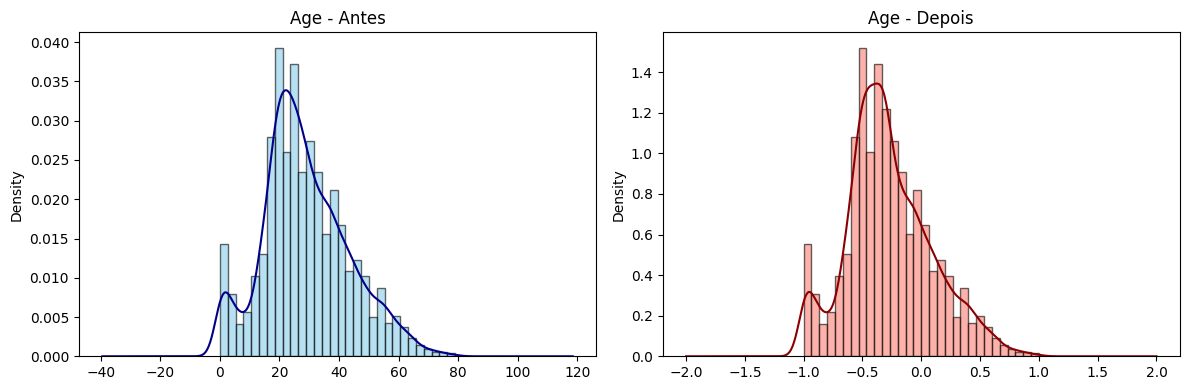

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(titanic_df["Age"], bins=30, color="skyblue", edgecolor="black", alpha=0.6, density=True)
titanic_df["Age"].plot(kind="kde", ax=axes[0], color="darkblue")
axes[0].set_title("Age - Antes")

axes[1].hist(X["Age"], bins=30, color="salmon", edgecolor="black", alpha=0.6, density=True)
X["Age"].plot(kind="kde", ax=axes[1], color="darkred")
axes[1].set_title("Age - Depois")

plt.tight_layout()
plt.show()


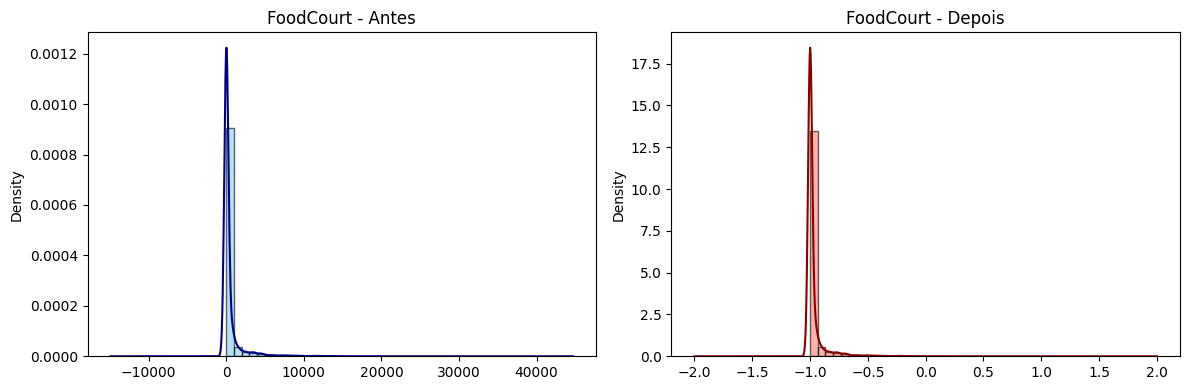

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(titanic_df["FoodCourt"], bins=30, color="skyblue", edgecolor="black", alpha=0.6, density=True)
titanic_df["FoodCourt"].plot(kind="kde", ax=axes[0], color="darkblue")
axes[0].set_title("FoodCourt - Antes")

axes[1].hist(X["FoodCourt"], bins=30, color="salmon", edgecolor="black", alpha=0.6, density=True)
X["FoodCourt"].plot(kind="kde", ax=axes[1], color="darkred")
axes[1].set_title("FoodCourt - Depois")

plt.tight_layout()
plt.show()